<a href="https://colab.research.google.com/github/vadim-privalov/Neiroset_Novosibirsk/blob/main/%D0%A0%D0%B0%D1%81%D0%BF%D0%BE%D0%B7%D0%BD%D0%B0%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D1%87%D0%B5%D0%BA%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Распознавание чеков 

# Check recognition 


В этом уроке мы научимся  использовать **OpenCV** для обнаружения, извлечения и преобразования чеков из входного изображения, а затем **Tesseract** для извлечения текста из них. 


In this lesson, we will learn how to use **OpenCV** to detect, extract and convert checks from an input image, and then **Tesseract** to extract text from them. 


In [1]:
# установим и распакуем архив
# install and unpack the archive
!wget http://dataudt.ru/datasets/cv/Lesson_12.OCR_receipt.zip
!unzip -qq Lesson_12.OCR_receipt.zip
%cd OCR_receipt

--2022-02-10 07:28:24--  http://dataudt.ru/datasets/cv/Lesson_12.OCR_receipt.zip
Resolving dataudt.ru (dataudt.ru)... 37.228.117.130
Connecting to dataudt.ru (dataudt.ru)|37.228.117.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14398540 (14M) [application/zip]
Saving to: ‘Lesson_12.OCR_receipt.zip’

Lesson_12.OCR_recei 100%[===================>]  13.73M  10.1MB/s    in 1.4s    

2022-02-10 07:28:25 (10.1 MB/s) - ‘Lesson_12.OCR_receipt.zip’ saved [14398540/14398540]

/content/OCR_receipt


Настроим работу tesseract 

Let's set up a tesseract 


In [2]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-11-1 cuda-nsight-compute-10-0
  cuda-nsight-compute-10-1 cuda-nsight-compute-11-0 cuda-nsight-compute-11-1
  cuda-nsight-systems-10-1 cuda-nsight-systems-

In [3]:
import pytesseract

pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

In [4]:
!mv "/content/OCR_receipt/rus.traineddata" "/usr/share/tesseract-ocr/4.00/tessdata/"

In [5]:
# импортируем необходимые пакеты
# import the necessary packages
from imutils.perspective import four_point_transform
from google.colab.patches import cv2_imshow
import pytesseract
import argparse
import imutils
import cv2
import re

In [6]:
# создадим отдельный словарь с аргументами 
# create a separate dictionary with arguments 

args = {
  "image" : "/content/OCR_receipt/ex1.jpg", # путь к входному изображению, которое мы будем распознавать
                                            # the path to the input image we are going to recognize
  "debug": 1, # визуализируем ли мы каждый шаг конвейера  (при -1 не будем)
                 # whether we visualize each step of the conveyor (at -1 we will not)
}

Input


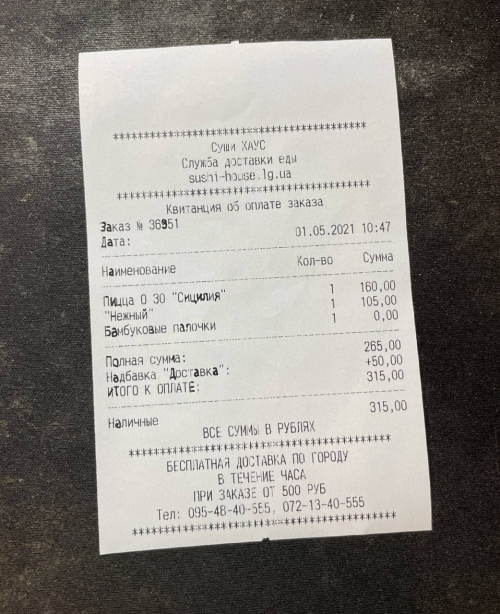

Edged


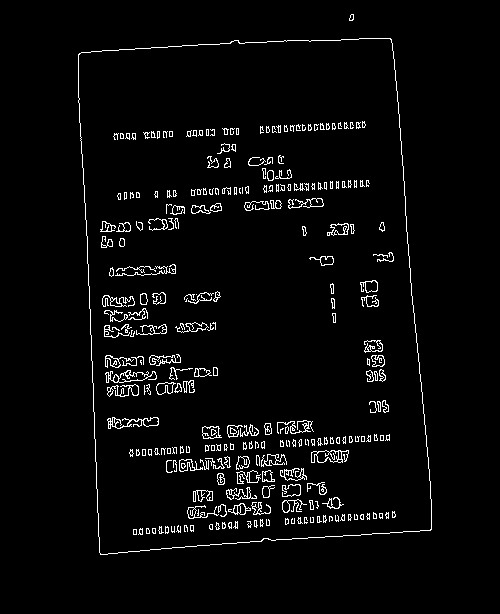

Receipt Outline


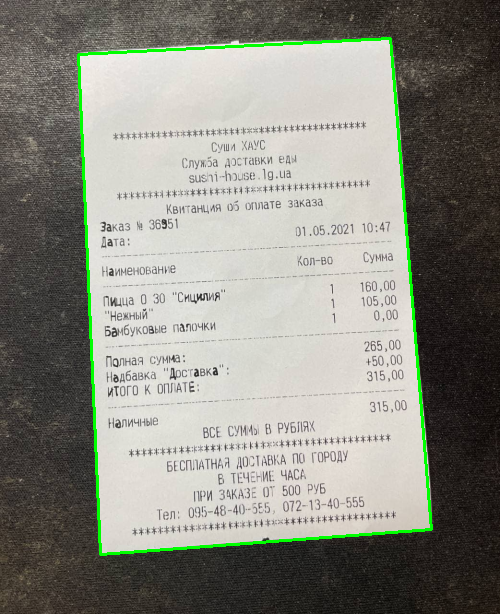

Receipt Transform


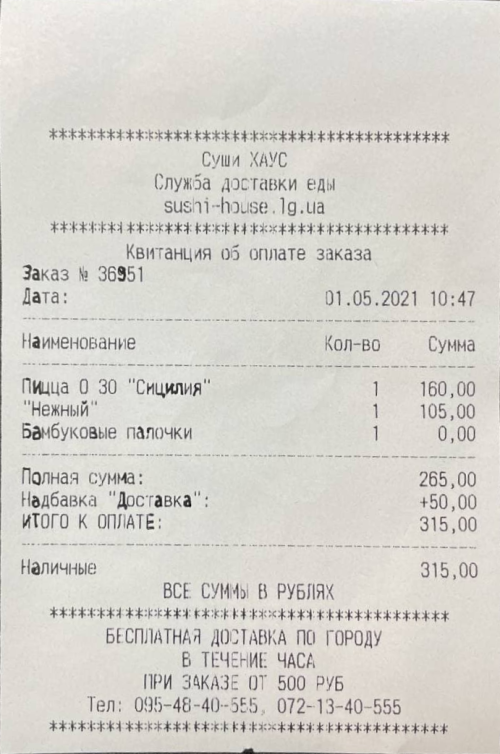

[INFO] raw output:
жюнеееюнююренюнеюнннеюсзавнючевереюнеюнююжж
Суши ХАУС
Служба доставки еды
зизлі —лоиве . 19 „иа
завнеобюеювевеневюневоовюючннюненененюсся
Квитанция 0б оплате заказа
Заказ № 36851

Дата 01 05. 2021 10;47
Наименование Коп—во Сумма
пИцца 0 30 ‘ Сицилия“ 1 160,00

”Нежный” 1 105,00
Бамбуковые палочки 1 0,00
Полнач сумма : 265,00
Надбавка ”Доставка” : +50,00

итого к ОППАТЕ

 

Напичные
ВСЕ СУММЫ В РУБЛЯХ
жевеовезеювенехвбюкюнюсовенаюнеююнеюнюннся
БЕСПЛАТНАЯ. ДОСТАВКА. По ГОРОДУ
В ТЕЧЕНИЕ ЧАСА
ПРИ ЗАКАЗЕ ОТ 500 РУБ
Тел: 095—48—40—555, 072—13—40—555
жнвюзвезеюнннюневеневосеюнинюнервюнюючк

>00 веокооренее ве в о ед меаееае и 2 >



[INFO] price line items:
пИцца 0 30 ‘ Сицилия“ 1 160,00
”Нежный” 1 105,00
Бамбуковые палочки 1 0,00
Полнач сумма : 265,00
Надбавка ”Доставка” : +50,00


In [7]:
# загружаем входное изображение, изменяем его размер и вычисляем 
# отношение *новой* ширины к *старой* ширине
# load the input image from disk, resize it, and compute the ratio
# of the *new* width to the *old* width
orig = cv2.imread(args["image"])
image = orig.copy()
image = imutils.resize(image, width=500)
ratio = orig.shape[1] / float(image.shape[1])

# преобразуем изображение в градации серого, 
# слегка размываем его, а затем применяем определение краев
# convert the image to grayscale, blur it slightly, and then apply
# edge detection
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5,), 0)
edged = cv2.Canny(blurred, 75, 200)

# если включена отладка, то показываем результат нашей процедуры 
# обнаружения краев
# check to see if we should show the output of our edge detection
# procedure
if args["debug"] > 0:
    print("Input")
    cv2_imshow(image)
    print("Edged")
    cv2_imshow(edged)

# находим контуры на карте граней и сортируем их по размеру
# в порядке убывания
# find contours in the edge map and sort them by size in descending
# order
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

# инициализируем контур, соответствующий контуру квитанции
# initialize a contour that corresponds to the receipt outline
receiptCnt = None

# проходим по контуру 
# loop over the contours
for c in cnts:
    # находим приближенный контур 
    # approximate the contour
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.02 * peri, True)

    # если наш аппроксимированный контур имеет четыре 
    # точки, то можно считать, что мы нашли контур чека
    # if our approximated contour has four points, then we can
	# assume we have found the outline of the receipt
	if len(approx) == 4:
		receiptCnt = approx
		break

# если контур пуст, то скрипт выдает ошибку
# if the receipt contour is empty then our script could not find the
#  outline of the receipte so raise an error
if receiptCnt is None:
	raise Exception(("Could not find receipt outline. "
		"Try debugging your edge detection and contour steps."))

# если включена отладка, то рисуем контур чека на изображении
# check to see if we should draw the contour of the receipt on the
# image and then display it to our screen
if args["debug"] > 0:
    output = image.copy()
    cv2.drawContours(output, [receiptCnt], -1, (0, 255, 0), 2)
    print("Receipt Outline")
    cv2_imshow(output)

# применим преобразование перспективы в четырех точках к *оригинальному* 
# изображению, чтобы получить вид сверху вниз с высоты птичьего полета 
# apply a four point perspective transform to the *original* image to
# obtain a top-down birds eye view of the receipt
receipt = four_point_transform(orig, receiptCnt.reshape(4, 2) * ratio)

# показываем преобразованное изображение
# show transformed image
print("Receipt Transform")
cv2_imshow( imutils.resize(receipt, width=500))
cv2.waitKey(0)

# применяем OCR к изображению чека, принимая данные столбцов, 
# обеспечивая конкатенацию текста по всей строке (+ можно добавить 
# дополнительную обработку для очистки изображения, включая изменение 
# размера, пороговое значение и т.д. для собственных изображений)
# apply OCR to the receipt image by assuming column data, ensuring
# the text is *concatenated across the row* (additionally, for your
# own images you may need to apply additional processing to cleanup
# the image, including resizing, thresholding, etc.)
options = "--psm 4"
text = pytesseract.image_to_string(
	cv2.cvtColor(receipt, cv2.COLOR_BGR2RGB),
	config=options, lang='rus')

# показываем пока что необработанный результат 
# show the raw output of the OCR process
print("[INFO] raw output:")
print("==================")
print(text)
print("\n")

# напишем регулярное выражение, которое будет искать строки, 
# включающие цену
# define a regular expression that will match line items that include
# a price component
pricePattern = r'([0-9]+\,[0-9]+)'


# показываем результат фильтрации строк в чеке
# show the output of filtering out *only* the line items in the
# receipt
print("[INFO] price line items:")
print("========================")

# перебираем каждую строку в чеке с расшифровкой
# loop over each of the line items in the OCR'd receipt
for row in text.split("\n"):
    # проверяем, соответствует ли регулярное выражение текущей строке,
    # если да, то выводим 
    # check to see if the price regular expression matches the current
    # row
    if re.search(pricePattern, row) is not None:
        print(row)

Совет: фотографируйте чеки на темном матовом фоне, так чек более точно выделится 

Tip: Photograph checks on a dark matte background, so the check will stand out more accurately 